In [2]:
# libraries
import numpy as np
import pandas as pd
import random
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [38]:
#Columns/Features
D = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
L = ['Sex']
C = 'Rings'
DL = D + L
DLC = D + [L] + [C]
DC = D + [C]


# #Loading Data set
abalone = pd.read_csv("../datasets/abalone.csv", sep=',')


In [39]:
# print(f'Data: shape={abalone[D].shape}')
# display("describe",abalone[D].describe())
# display("skew:",abalone[D].skew())
# display("kurtosis", abalone[D].kurtosis())
# display("variance", abalone[D].std())

feature_range = abalone[D].max() - abalone[D].min()
# display("range:")
# display(feature_range)


# sns.histplot(abalone['Height'], bins=30, kde=True)  
# plt.title("Height Feature Distribution")
# plt.show()

Q1 = abalone['Height'].quantile(0.25)
Q3 = abalone['Height'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
abalone = abalone[(abalone['Height'] >= lower_bound) & (abalone['Height'] <= upper_bound)]
# print(f'Data: shape after removing outliers={abalone[D].shape}')
# display("kurtosis", abalone[D].kurtosis())

# sns.countplot(x =abalone[C])
# plt.title("Class Distribution")
# plt.show()

# sns.countplot(x = abalone[C])
# plt.title("Class Distribution before  sorting")
# plt.show()


X = abalone[DL]
y = abalone[C]

#splitting the target variable into buckets to make it a balanced classification problem
# value_counts = y.value_counts().sort_index()
# cumulative_counts = value_counts.cumsum()
# total_samples = cumulative_counts.max()
# num_buckets = 5

# percentiles = np.linspace(0, 1, num_buckets + 1)  # Create bin edges
# bin_edges = np.percentile(y, percentiles * 100) #find boundaries
# bin_labels = range(1, num_buckets + 1)

# y_bucket = pd.cut(y, bins=bin_edges, labels=range(1, num_buckets + 1), include_lowest=True)

# ring_to_category = pd.DataFrame({'Original_Rings': y, 'Binned_Category': y_bucket})
# ring_to_category = ring_to_category.drop_duplicates().sort_values(by='Original_Rings')
# display(ring_to_category)

# class_1_subset = X[y_bucket == 1]
# class_1_subset_y = y_bucket[y_bucket == 1] 
# class_1_indices = y_bucket[y_bucket == 1].index  # Get indices of class 1
# other_class_indices = y_bucket[y_bucket != 1].index  # Get indices of other classes
# class_1_sampled_indices = np.random.choice(class_1_indices, size=700, replace=False)  # Choose 500 random samples
# final_indices = np.concatenate([class_1_sampled_indices, other_class_indices])


# # Step 3: Use these indices to select from X and y
# X = X.loc[final_indices] 
# y = y_bucket.loc[final_indices] 

# abalone = pd.concat([X, y], axis=1)
# abalone = shuffle(abalone, random_state=42)
# abalone = abalone.rename(columns={'Rings': 'Rings_Bucket'})

# sns.countplot(x=abalone['Rings_Bucket'])
# plt.title("Class Distribution after sorting")
# plt.show()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(abalone[L])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(L), index=abalone.index)
# Drop categorical columns and replace with encoded ones
abalone = abalone.drop(columns=L).join(encoded_df)

# display(abalone.head(20))

# subset = ['Length', 'Diameter', 'Height', 'Rings_Bucket']
# sns.pairplot(abalone[subset], hue='Rings_Bucket')
# plt.show()


scaler = StandardScaler()
#standardize everything except target variable and one-hot-encoding
numeric_features = abalone.columns[0:-4]
abalone[numeric_features] = scaler.fit_transform(abalone[numeric_features])

# display("after normalizing",abalone[D].describe())
X = abalone[D + list(encoded_df.columns)]
y = abalone[C]



Best k: 15 with RMSE: 1.4920
Variance of RMSE: 0.0029


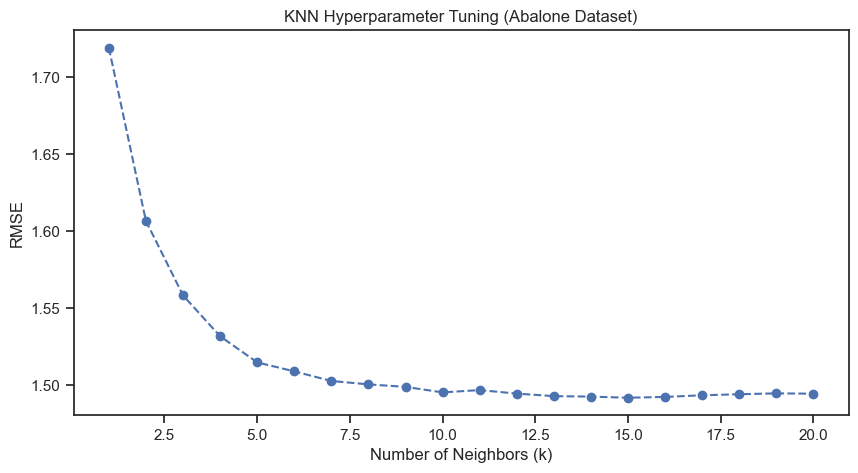

In [41]:
#K Nearest Neighbors Regressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt


# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store RMSE for each fold
rmse_scores = []

# Try different values for n_neighbors to tune KNN
best_k = None
best_rmse = float('inf')

for k in range(1, 21):  # Tuning from k=1 to 20
    fold_rmse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train KNN Regressor
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Predict and compute RMSE
        y_pred = knn.predict(X_test)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    rmse_scores.append(avg_rmse)

    # Track best k value
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_k = k

print(f"Best k: {best_k} with RMSE: {best_rmse:.4f}")
print(f"Variance of RMSE: {np.var(rmse_scores):.4f}")


# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), rmse_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('KNN Hyperparameter Tuning (Abalone Dataset)')
plt.show()

#best k = 11






Best max_depth: 5 with RMSE: 1.5307
Variance of RMSE: 0.0054


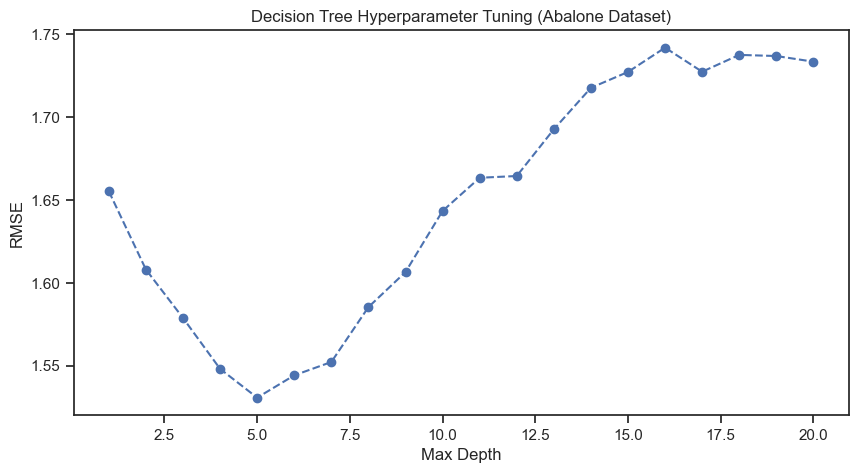

In [42]:
#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor


# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store RMSE for each fold
rmse_scores = []

# Try different values for max_depth to tune DecisionTreeRegressor
best_depth = None
best_rmse = float('inf')
depth_range = range(1, 21)  # Tuning from depth=1 to 20

for depth in depth_range:
    fold_rmse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train Decision Tree Regressor
        dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
        dt.fit(X_train, y_train)

        # Predict and compute RMSE
        y_pred = dt.predict(X_test)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    rmse_scores.append(avg_rmse)

    # Track best depth value
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_depth = depth

print(f"Best max_depth: {best_depth} with RMSE: {best_rmse:.4f}")
print(f"Variance of RMSE: {np.var(rmse_scores):.4f}")

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(depth_range, rmse_scores, marker='o', linestyle='dashed')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Decision Tree Hyperparameter Tuning (Abalone Dataset)')
plt.show()

#best depth = 5

Best n_estimators: 300 with RMSE: 1.4822
Variance of RMSE: 0.0002


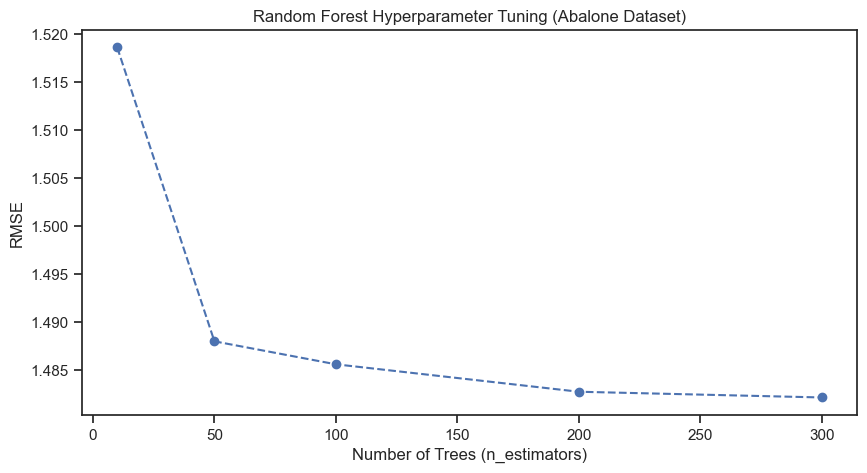

In [43]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store RMSE for each fold
rmse_scores = []

# Try different values for n_estimators (number of trees) to tune RandomForestRegressor
best_n = None
best_rmse = float('inf')
n_estimators_range = [10, 50, 100, 200, 300]  # Tuning different tree counts

for n in n_estimators_range:
    fold_rmse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train Random Forest Regressor
        rf = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)

        # Predict and compute RMSE
        y_pred = rf.predict(X_test)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    rmse_scores.append(avg_rmse)

    # Track best n_estimators value
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_n = n

print(f"Best n_estimators: {best_n} with RMSE: {best_rmse:.4f}")
print(f"Variance of RMSE: {np.var(rmse_scores):.4f}")

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, rmse_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Random Forest Hyperparameter Tuning (Abalone Dataset)')
plt.show()

#best n_estimators = 200

Best n_estimators: 100 with RMSE: 1.4796
Variance of RMSE: 0.0013


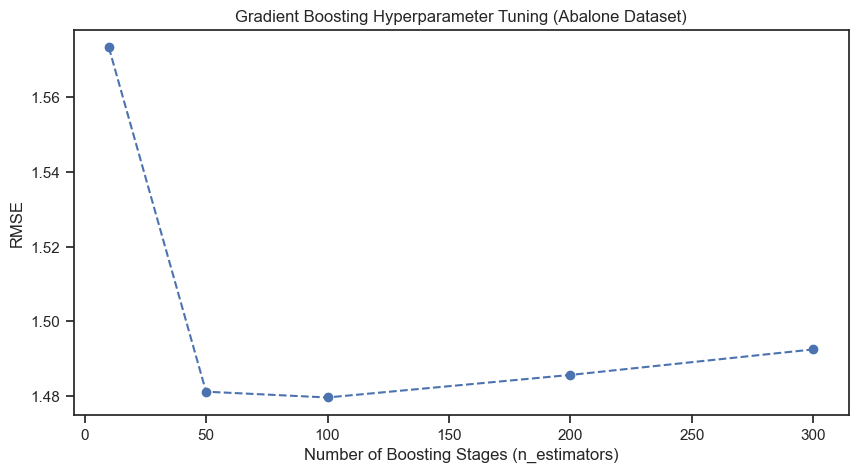

In [45]:
#Gradient Tree Boosted Regressor
#Gradient Tree Boosted Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Define features (X) and target (y)

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store RMSE for each fold
rmse_scores = []

# Try different values for n_estimators (number of boosting stages) to tune GradientBoostingRegressor
best_n = None
best_rmse = float('inf')
n_estimators_range = [10, 50, 100, 200, 300]  # Tuning different boosting stages

for n in n_estimators_range:
    fold_rmse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train Gradient Boosting Regressor
        gbr = GradientBoostingRegressor(n_estimators=n, random_state=42)
        gbr.fit(X_train, y_train)

        # Predict and compute RMSE
        y_pred = gbr.predict(X_test)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    rmse_scores.append(avg_rmse)

    # Track best n_estimators value
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_n = n

print(f"Best n_estimators: {best_n} with RMSE: {best_rmse:.4f}")
print(f"Variance of RMSE: {np.var(rmse_scores):.4f}")

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, rmse_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Boosting Stages (n_estimators)')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Hyperparameter Tuning (Abalone Dataset)')
plt.show()

#best number of boosting stages = 100

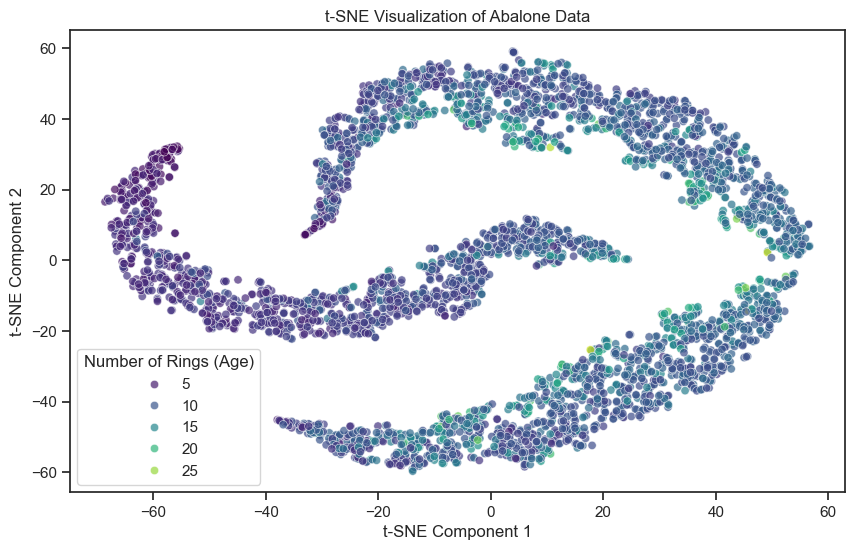

In [46]:
#3.1 Representation Learning 
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # Adjust perplexity if needed
X_tsne = tsne.fit_transform(X)

# Ensure y has a matching index
y = y.reset_index(drop=True)
# y = np.ravel(y)  # Convert y to 1D array if needed

# Convert to DataFrame for plotting
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Rings'] = y  # Number of rings (proxy for age)

# Plot t-SNE visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue=tsne_df['Rings'], palette='viridis', alpha=0.7, data=tsne_df)
plt.title("t-SNE Visualization of Abalone Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Number of Rings (Age)")
plt.show()




Explained Variance by PC1: 0.8593
Explained Variance by PC2: 0.0449
Total Explained Variance (PC1 + PC2): 0.9042


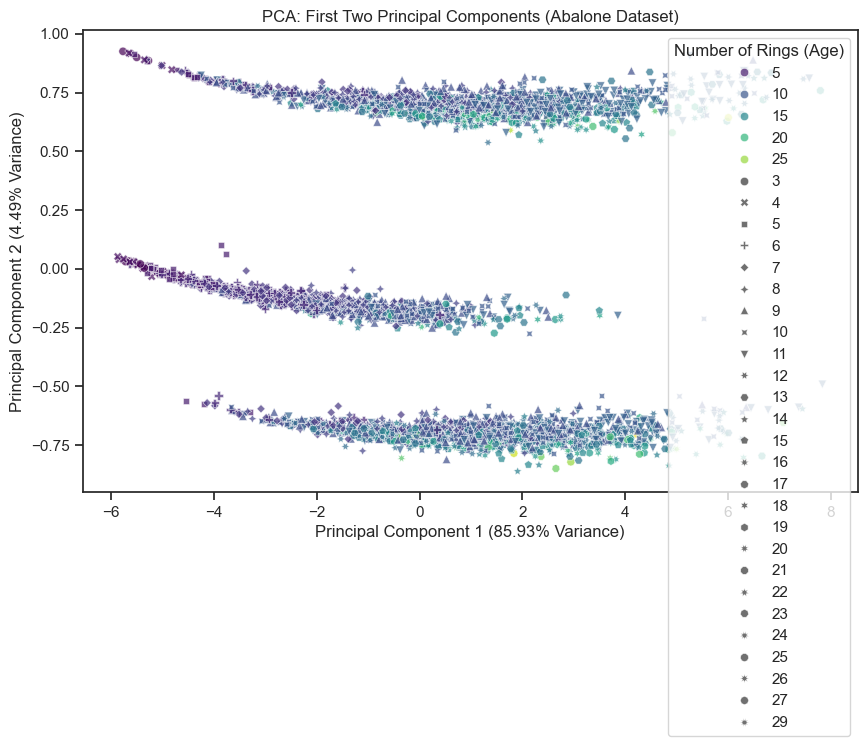

In [47]:
#3.2
from sklearn.decomposition import PCA

# Run PCA to extract principal components
pca = PCA(n_components=2)  # Reduce to 2D
X_pca = pca.fit_transform(X)

# Convert to DataFrame for easier plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Rings'] = y.reset_index(drop=True)  # Ensure matching index

# Print variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by PC1: {explained_variance[0]:.4f}")
print(f"Explained Variance by PC2: {explained_variance[1]:.4f}")
print(f"Total Explained Variance (PC1 + PC2): {np.sum(explained_variance):.4f}")

# Create PCA scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=pca_df['Rings'], palette='viridis', style=pca_df['Rings'], markers=True, data=pca_df, alpha=0.7)
plt.title("PCA: First Two Principal Components (Abalone Dataset)")
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)")
plt.legend(title="Number of Rings (Age)")
plt.show()



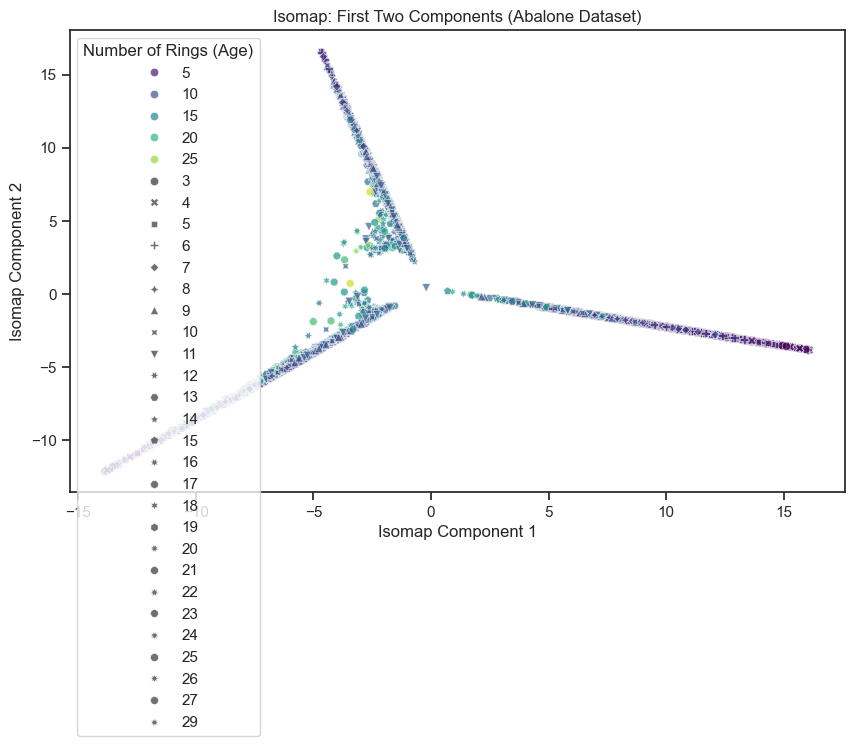

In [36]:
#3.3
from sklearn.manifold import Isomap

# Run Isomap to extract components
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X)

# Convert to DataFrame for easier plotting
isomap_df = pd.DataFrame(X_isomap, columns=['ISOMAP1', 'ISOMAP2'])
isomap_df['Rings'] = y.reset_index(drop=True)  # Ensure matching index

# Create Isomap scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ISOMAP1', y='ISOMAP2', hue=isomap_df['Rings'], palette='viridis', style=isomap_df['Rings'], markers=True, data=isomap_df, alpha=0.7)
plt.title("Isomap: First Two Components (Abalone Dataset)")
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.legend(title="Number of Rings (Age)")
plt.show()



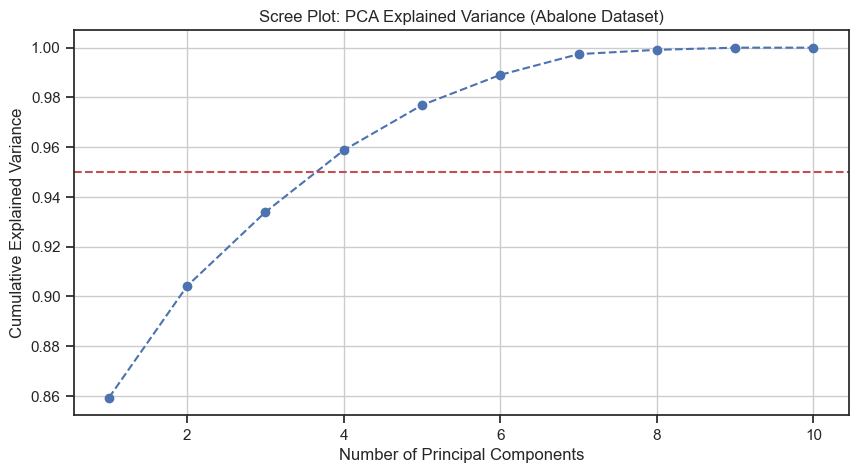

Optimal number of PCA components: 4


In [48]:
#3.4 scree-plot and reduced datasets

# Step 1: Compute PCA on full dataset
pca = PCA()
X_pca_full = pca.fit_transform(X)

# Step 2: Scree plot - variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--')  # Mark 95% variance line
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: PCA Explained Variance (Abalone Dataset)')
plt.grid()
plt.show()

# Step 3: Determine the best reduced dimension size (where cumulative variance ~95%)
best_pca_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of PCA components: {best_pca_components}")

# Step 4: Create PCA-reduced dataset
pca = PCA(n_components=best_pca_components)
X_pca = pca.fit_transform(X)
abalone_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(best_pca_components)])
abalone_pca['Rings'] = y.reset_index(drop=True)

# Step 5: Create Isomap-reduced dataset (same number of components as PCA)
isomap = Isomap(n_components=best_pca_components)
X_isomap = isomap.fit_transform(X)
abalone_isomap = pd.DataFrame(X_isomap, columns=[f'ISOMAP{i+1}' for i in range(best_pca_components)])
abalone_isomap['Rings'] = y.reset_index(drop=True)

# Save the datasets to CSV files for future testing
abalone_pca.to_csv("../datasets/abalone-pca.csv", index=False)
abalone_isomap.to_csv("../datasets/abalone-isomap.csv", index=False)


In [49]:
#3.5
# Load datasets
X_pca = pd.read_csv("../datasets/abalone-pca.csv", header=0).iloc[:, :-1]  # Exclude target column
X_isomap = pd.read_csv("../datasets/abalone-isomap.csv", header=0).iloc[:, :-1]  # Exclude target column

datasets = {
    "abalone": X,  # Standard dataset
    "abalone-pca": X_pca,  # PCA-transformed dataset
    "abalone-isomap": X_isomap  # Isomap-transformed dataset
}

# Define models with best hyperparameters
models = {
    "k-NN": KNeighborsRegressor(n_neighbors=11),  # Best k from tuning
    "RF": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),  # Example best params
    "GB": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)  # Example best params
}

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

# Iterate over each dataset and model combination
for dataset_name, X in datasets.items():
    for model_name, model in models.items():
        fold_rmse = []
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
            fold_rmse.append(rmse)
        
        avg_rmse = np.mean(fold_rmse)
        results.append([dataset_name, model_name, avg_rmse])

# Convert results to DataFrame and display
results_df = pd.DataFrame(results, columns=["Dataset", "Model", "RMSE"])
display(results_df)



,Dataset,Model,RMSE
0,abalone,k-NN,1.496982
1,abalone,RF,1.476987
2,abalone,GB,1.478864
3,abalone-pca,k-NN,1.573389
4,abalone-pca,RF,1.545606
5,abalone-pca,GB,1.545350
6,abalone-isomap,k-NN,1.562920
7,abalone-isomap,RF,1.554842
8,abalone-isomap,GB,1.559683
